# Classifying into 3 types

In this notebook I classify astronomical images into 3 types, stars, spiral galaxies and ellipitical galaxies. That are the three most common types of astronomical objects.

In [1]:
#standard libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.cm as cm
import sys
import os
import time
import random as random
from astropy.io import fits
#torch functions
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
#sklearn helper functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score,f1_score, log_loss
#xgboost for comparison
from xgboost import XGBClassifier
#logistic regression for comparison 
from sklearn.linear_model import LogisticRegression
import pickle
from functions_ml import *

First I get the galaxy data, in the same way as for the galaxy classification. 
It is produced by the program get_zoo_galaxies.py.  The is applied  43 times and thus gets data from 43 fields. This fields cover the area from 310 (-50) degree to 60 degree in right ascension with a height from -1.26 to +1.26  degree in Declination. 

The data consist of two pieces, firstly the images, which were saved as 4 dimensions (1 dimension x of image, second y of image, third channels, forth image in order or batch on torch language) numpy arrays, because torch needs 4d arrays, even when as here only a single channel exist. The image are rdeep images from http://research.iac.es/proyecto/stripe82/pages/data.php
This channel is the channel combination with the highest signal to noise ratio. Secondly, information on each images is loaded as data frame, that are in particular the classes spiral and elliptical which are boolean and exclusive here. There are citizen zoo classifications from the zoo projects. Only rather certain ones I included here, but there is no 100% certainty. 

In [2]:
#getting the list of images
myPath='/home/tobias/ml-testing/astr-images'
list_images=[f for f in os.listdir(myPath) 
    if f.endswith('_ell_spiral_im.npy') ]
list_images.sort()
print(len(list_images))
#getting the list of tables 
list_tables=[f for f in os.listdir(myPath) 
    if f.endswith('_ell_spiral_table.csv')]
list_tables.sort()
print(len(list_tables))

43
43


Next I combine the images.

In [3]:
cutouts_gal=comb_nump_4d(list_images)
print(cutouts_gal.shape)

(43, 43, 1, 7875)


Next combining the tables. 

In [4]:
list_df_gal=[]
for i in range(len(list_tables)):
    i=pd.read_csv(list_tables[i])
    list_df_gal.append(i)  
print(f"number of tables is {len(list_df_gal)}")    
df_gal=pd.concat(list_df_gal,ignore_index=True)
print(f"shape of combined data frame {df_gal.shape}")
print(f"shape of image file is {cutouts_gal.shape}")

number of tables is 43
shape of combined data frame (7875, 51)
shape of image file is (43, 43, 1, 7875)


The images and the classification data has the same lengths. Now I am looking on classes. 

In [5]:
print(df_gal.spiral.value_counts())

1    5766
0    2109
Name: spiral, dtype: int64


The classes are somewhat inbalanced, the ones which are not spiral are ellipticals. 

Next I get stars, the images have the same size as the galaxies since that is needed for 3 way classification even although star can distinguished with a smaller window also. 

In [6]:
#getting the list of star images
list_images_star=[f for f in os.listdir(myPath) 
    if f.endswith('_stars_im.npy') ]
list_images_star.sort()
print(list_images)
#getting the list of star tables 
list_tables_star=[f for f in os.listdir(myPath) 
    if f.endswith('_stars_table.csv')]
list_tables_star.sort()
print(list_tables_star)

['stripe82_01_ell_spiral_im.npy', 'stripe82_02_ell_spiral_im.npy', 'stripe82_03_ell_spiral_im.npy', 'stripe82_04_ell_spiral_im.npy', 'stripe82_05_ell_spiral_im.npy', 'stripe82_06_ell_spiral_im.npy', 'stripe82_07_ell_spiral_im.npy', 'stripe82_08_ell_spiral_im.npy', 'stripe82_09_ell_spiral_im.npy', 'stripe82_10_ell_spiral_im.npy', 'stripe82_11_ell_spiral_im.npy', 'stripe82_12_ell_spiral_im.npy', 'stripe82_13_ell_spiral_im.npy', 'stripe82_14_ell_spiral_im.npy', 'stripe82_15_ell_spiral_im.npy', 'stripe82_16_ell_spiral_im.npy', 'stripe82_17_ell_spiral_im.npy', 'stripe82_18_ell_spiral_im.npy', 'stripe82_19_ell_spiral_im.npy', 'stripe82_20_ell_spiral_im.npy', 'stripe82_21_ell_spiral_im.npy', 'stripe82_22_ell_spiral_im.npy', 'stripe82_23_ell_spiral_im.npy', 'stripe82_24_ell_spiral_im.npy', 'stripe82_25_ell_spiral_im.npy', 'stripe82_26_ell_spiral_im.npy', 'stripe82_27_ell_spiral_im.npy', 'stripe82_28_ell_spiral_im.npy', 'stripe82_29_ell_spiral_im.npy', 'stripe82_30_ell_spiral_im.npy', 'stripe82

Combining them now.

In [7]:
cutouts_star=comb_nump_4d(list_images_star)
print(cutouts_star.shape)
list_df_star=[]
for i in range(len(list_tables_star)):
    i=pd.read_csv(list_tables_star[i])
    list_df_star.append(i)  
df_star=pd.concat(list_df_star,ignore_index=True)
print(f"shape of combined data frame {df_star.shape}")
print(f"shape of image file is {cutouts_star.shape}")

(43, 43, 1, 31530)
shape of combined data frame (31530, 48)
shape of image file is (43, 43, 1, 31530)


Thast are more than 30000 here, clearly more than before. Adding so many of them likely mainly adds computing time. Therefore I now only use 20% of all. That might be increased at some point. 

In [8]:
#images and df split
im_star_used, im_star_other,df_star_used, df_star_other = train_test_split(cutouts_star.T,df_star,train_size=0.20, shuffle=True, random_state=1)
print("shape of used star image data is")
print(im_star_used.shape)

shape of used star image data is
(6306, 1, 43, 43)


Creating new data frame, combining some properties of the two old ones. 

In [9]:
print(df_star_used.columns,df_gal.columns)
#adding spiral class of 2 for stars 
df_star_used['spiral']=2
df_all=pd.concat([df_star_used,df_gal],ignore_index=True)

Index(['Unnamed: 0', 'index', 'objid', 'ra', 'dec', 'psfMag_u', 'psfMag_g',
       'psfMag_r', 'psfMag_i', 'psfMag_z', 'probPSF_u', 'probPSF_g',
       'probPSF_r', 'probPSF_i', 'probPSF_z', 'modelMag_u', 'modelMag_g',
       'modelMag_r', 'modelMag_i', 'modelMag_z', 'petroRad_g', 'petroRad_r',
       'petroRad_i', 'run', 'rerun', 'camcol', 'field', 'type', 'specobjid',
       'class', 'subclass', 'redshift', 'zErr', 'zWarning', 'zErr_noqso',
       'zWarning_noqso', 'z_noqso', 'snMedian_r', 'snMedian_i', 'z_person',
       'class_person', 'plate', 'mjd', 'fiberid', 'image', 'pixel_x',
       'pixel_y', 'off_image'],
      dtype='object') Index(['Unnamed: 0', 'index', 'objid', 'ra', 'dec', 'psfMag_u', 'psfMag_g',
       'psfMag_r', 'psfMag_i', 'psfMag_z', 'probPSF_u', 'probPSF_g',
       'probPSF_r', 'probPSF_i', 'probPSF_z', 'modelMag_u', 'modelMag_g',
       'modelMag_r', 'modelMag_i', 'modelMag_z', 'petroRad_g', 'petroRad_r',
       'petroRad_i', 'run', 'rerun', 'camcol', 'field', '

Analysing output.

In [10]:
print(df_all.shape,df_gal.shape,df_star_used.shape,df_all.columns,df_all.describe(),df_all.spiral,df_all.spiral.value_counts())

(14181, 60) (7875, 51) (6306, 49) Index(['Unnamed: 0', 'index', 'objid', 'ra', 'dec', 'psfMag_u', 'psfMag_g',
       'psfMag_r', 'psfMag_i', 'psfMag_z', 'probPSF_u', 'probPSF_g',
       'probPSF_r', 'probPSF_i', 'probPSF_z', 'modelMag_u', 'modelMag_g',
       'modelMag_r', 'modelMag_i', 'modelMag_z', 'petroRad_g', 'petroRad_r',
       'petroRad_i', 'run', 'rerun', 'camcol', 'field', 'type', 'specobjid',
       'class', 'subclass', 'redshift', 'zErr', 'zWarning', 'zErr_noqso',
       'zWarning_noqso', 'z_noqso', 'snMedian_r', 'snMedian_i', 'z_person',
       'class_person', 'plate', 'mjd', 'fiberid', 'image', 'pixel_x',
       'pixel_y', 'off_image', 'spiral', 'nvote', 'p_el', 'p_cw', 'p_acw',
       'p_edge', 'p_dk', 'p_mg', 'p_el_debiased', 'p_cs_debiased',
       'elliptical', 'uncertain'],
      dtype='object')          Unnamed: 0         index         objid            ra           dec  \
count  14181.000000  14181.000000  1.418100e+04  14181.000000  14181.000000   
mean     281.428

Correct combined. Now also combining cutouts. 

In [11]:
print(im_star_used.shape,cutouts_gal.shape)
cutouts_all=np.zeros((im_star_used.shape[0]+cutouts_gal.shape[3],im_star_used.shape[1],im_star_used.shape[2],im_star_used.shape[3]))
cutouts_all[:im_star_used.shape[0],:,:,:]=im_star_used
cutouts_all[im_star_used.shape[0]:cutouts_all.shape[0],:,:,:]=cutouts_gal.T
print(cutouts_all.shape)

(6306, 1, 43, 43) (43, 43, 1, 7875)
(14181, 1, 43, 43)


 
Next I add the image pixel information to the data frame, these data will be used by the algorithms which do not work on images but on tables. I just run two loops within each other, thus the order is not particular meaningful. 

In [12]:
x=0
for i in range(cutouts_all.shape[2]):
    for j in range(cutouts_all.shape[3]):
        df_all[x]=cutouts_all[:,0,i,j]
        x+=1
print(df_all.describe())   

/tmp/ipykernel_2572/4093443453.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_all[x]=cutouts_all[:,0,i,j]
/tmp/ipykernel_2572/4093443453.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_all[x]=cutouts_all[:,0,i,j]
/tmp/ipykernel_2572/4093443453.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.

/tmp/ipykernel_2572/4093443453.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_all[x]=cutouts_all[:,0,i,j]
/tmp/ipykernel_2572/4093443453.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_all[x]=cutouts_all[:,0,i,j]
/tmp/ipykernel_2572/4093443453.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.

/tmp/ipykernel_2572/4093443453.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_all[x]=cutouts_all[:,0,i,j]
/tmp/ipykernel_2572/4093443453.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_all[x]=cutouts_all[:,0,i,j]
/tmp/ipykernel_2572/4093443453.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.

/tmp/ipykernel_2572/4093443453.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_all[x]=cutouts_all[:,0,i,j]
/tmp/ipykernel_2572/4093443453.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_all[x]=cutouts_all[:,0,i,j]
/tmp/ipykernel_2572/4093443453.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.

/tmp/ipykernel_2572/4093443453.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_all[x]=cutouts_all[:,0,i,j]
/tmp/ipykernel_2572/4093443453.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_all[x]=cutouts_all[:,0,i,j]
/tmp/ipykernel_2572/4093443453.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.

/tmp/ipykernel_2572/4093443453.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_all[x]=cutouts_all[:,0,i,j]
/tmp/ipykernel_2572/4093443453.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_all[x]=cutouts_all[:,0,i,j]
/tmp/ipykernel_2572/4093443453.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.

         Unnamed: 0         index         objid            ra           dec  \
count  14181.000000  14181.000000  1.418100e+04  14181.000000  14181.000000   
mean     281.428743   1833.972146  1.237664e+18    152.106353     -0.004695   
std      333.470121   2543.948469  5.535602e+12    152.104392      0.703123   
min        0.000000      0.000000  1.237646e+18      0.017176     -1.248046   
25%       75.000000    211.000000  1.237660e+18     20.487422     -0.605144   
50%      155.000000    451.000000  1.237664e+18     47.265140     -0.005213   
75%      364.000000   2871.000000  1.237664e+18    330.210817      0.593672   
max     2365.000000  15086.000000  1.237680e+18    359.996996      1.247670   

           psfMag_u      psfMag_g      psfMag_r      psfMag_i      psfMag_z  \
count  14181.000000  14181.000000  14181.000000  14181.000000  14181.000000   
mean      20.439248     18.767502     17.999241     17.610889     17.294351   
std        1.477539      1.331138      1.271196    

Next I am checking between which column numbers is the image pixel information.

In [13]:
print(df_all.columns[60],df_all.columns[1908])

0 1848


Next I am splitting the data set into test and train. There are two feature variants, one is the standard tables for everything besides convolutional network and the other is the image data set for the convoltiomnal network.

I use a 50% split here, because in tne first iteration I also want to figure out, which are wrong classified by excluding it from the fit. The easiest way to do it, is a 50/50 split. 

In [14]:
#images_test/train are feature for vonvolutional network 
feature_train, feature_test, target_train, target_test,image_train,image_test,df_train,df_test= train_test_split(df_all.iloc[:,60:1908],df_all.loc[:,"spiral"],cutouts_all,df_all,train_size=0.50, shuffle=True, random_state=1)
print("shape of image train data is")
print(image_train.shape)

shape of image train data is
(7090, 1, 43, 43)


I start with not neural network methods for classification, first XGBoost,  in standard setting. 

In [16]:
xc1=XGBClassifier(max_depth=6).fit(feature_train,target_train)

In [50]:
train_pred=xc1.predict(feature_train)
test_pred=xc1.predict(feature_test)
train_pred_prob=xc1.predict_proba(feature_train)
test_pred_prob=xc1.predict_proba(feature_test)
conf_train = confusion_matrix(target_train, train_pred)
conf_test = confusion_matrix(target_test, test_pred)
print("confusion matrix xgboost train")
print(conf_train)
print("confusion matrix xgboost test")
print(conf_test)

confusion matrix xgboost train
[[1093    0    0]
 [   0 2880    0]
 [   0    0 3117]]
confusion matrix xgboost test
[[ 901  108    7]
 [ 161 2724    1]
 [   2    2 3185]]


The star classification (2) is easy. That is not surprising since they are more clearly different. 
(Need to check at some point how much that depends on star brightness, for sure to some extent, question is whether it depends to much on it( 

Now I try logistic. A really high number of iterations would be needed for convergence, scaling features would help, but since it is obvious that regularization is needed and that logistic is rather likely not ideal I ignore that here

In [52]:
lc1=LogisticRegression(max_iter=6000,penalty='none').fit(feature_train,target_train)

/home/tobias/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [54]:
l_train_pred=lc1.predict(feature_train)
l_test_pred=lc1.predict(feature_test)
l_train_pred_prob=lc1.predict_proba(feature_train)
l_test_pred_prob=lc1.predict_proba(feature_test)
l_conf_train = confusion_matrix(target_train, l_train_pred)
l_conf_test = confusion_matrix(target_test, l_test_pred)
print("confusion matrix logistic regression train")
print(l_conf_train)
print("confusion matrix logistic regression test")
print(l_conf_test)

confusion matrix logistic regression train
[[1093    0    0]
 [   0 2880    0]
 [   0    0 3117]]
confusion matrix logistic regression test
[[ 568  445    3]
 [ 717 2164    5]
 [  26   15 3148]]


It is clearly worse as before when there were no stars in the sample. For galaxies the performance is similar as before. 

Now exploring the regularization grid for both. 

In [15]:
regs=[0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,1,3,10,30,100,300,1000,3000,10000]
stats_xgb=loop_xgboost(feature_train,target_train,feature_test,target_test,regs)
print(stats_xgb.T)
np.savetxt("xgb_43sets_gal-type_star_v1.txt",stats_xgb)

doing l2 regularization 0.0001
doing l2 regularization 0.0003
doing l2 regularization 0.001
doing l2 regularization 0.003
doing l2 regularization 0.01
doing l2 regularization 0.03
doing l2 regularization 0.1
doing l2 regularization 0.3
doing l2 regularization 1
doing l2 regularization 3
doing l2 regularization 10
doing l2 regularization 30
doing l2 regularization 100
doing l2 regularization 300
doing l2 regularization 1000
doing l2 regularization 3000
doing l2 regularization 10000
[[1.00000000e-04 1.00000000e+00 9.58255529e-01 8.66255598e-04
  1.33876565e-01]
 [3.00000000e-04 1.00000000e+00 9.59050059e-01 8.69338851e-04
  1.33007264e-01]
 [1.00000000e-03 1.00000000e+00 9.58023292e-01 9.11271909e-04
  1.35436993e-01]
 [3.00000000e-03 1.00000000e+00 9.59269903e-01 8.88429774e-04
  1.33443818e-01]
 [1.00000000e-02 1.00000000e+00 9.59144296e-01 9.07602499e-04
  1.32030803e-01]
 [3.00000000e-02 1.00000000e+00 9.61528550e-01 8.63149956e-04
  1.31540896e-01]
 [1.00000000e-01 1.00000000e+00 9.

Seems now clearly slower, but I am not sure, should log it. 

In [15]:
#only until now
#regs=[0.0000000001,0.000000003,0.00000001,0.00000003,0.0000001,0.0000003,0.000001,0.000003,0.00001,0.00003,0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,1,3,10,30,100]
#only until 0.01 now since not good after wards for sure 
regs=[0.0000000001,0.000000003,0.00000001,0.00000003,0.0000001,0.0000003,0.000001,0.000003,0.00001,0.00003,0.0001,0.0003,0.001,0.003,0.01]
print(regs)
start_time=time.time()
stats_log=loop_logistic(feature_train,target_train,feature_test,target_test,regs)
stop_time=time.time()
print(np.round(stats_log.T,5))
#from 0.01 iteration limit reached 
np.savetxt("log_43sets_gal-type_star_v1.txt",stats_log)
print(f"needed {np.round(stop_time-start_time,3)} seconds")
#1e-10 to 0.01 needed 3086.829 seconds 

[1e-10, 3e-09, 1e-08, 3e-08, 1e-07, 3e-07, 1e-06, 3e-06, 1e-05, 3e-05, 0.0001, 0.0003, 0.001, 0.003, 0.01]
doing l2 regularization 1e-10
doing l2 regularization 3e-09
doing l2 regularization 1e-08
doing l2 regularization 3e-08
doing l2 regularization 1e-07
doing l2 regularization 3e-07
doing l2 regularization 1e-06
doing l2 regularization 3e-06
doing l2 regularization 1e-05
doing l2 regularization 3e-05
doing l2 regularization 0.0001
doing l2 regularization 0.0003
doing l2 regularization 0.001
doing l2 regularization 0.003
doing l2 regularization 0.01


/home/tobias/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[0.0000e+00 7.0879e-01 7.2681e-01 6.6549e-01 6.5681e-01]
 [0.0000e+00 8.3934e-01 8.4276e-01 3.7076e-01 3.7498e-01]
 [0.0000e+00 8.5301e-01 8.5273e-01 3.1202e-01 3.2506e-01]
 [0.0000e+00 8.5937e-01 8.5952e-01 2.7776e-01 3.0143e-01]
 [0.0000e+00 8.6090e-01 8.6157e-01 2.5589e-01 2.9614e-01]
 [0.0000e+00 8.6677e-01 8.6307e-01 2.4418e-01 3.0242e-01]
 [0.0000e+00 8.7084e-01 8.6281e-01 2.3563e-01 3.1608e-01]
 [0.0000e+00 8.7192e-01 8.6536e-01 2.2871e-01 3.3868e-01]
 [1.0000e-05 8.7764e-01 8.6491e-01 2.2243e-01 4.0857e-01]
 [3.0000e-05 8.8574e-01 8.6619e-01 2.1207e-01 4.4856e-01]
 [1.0000e-04 8.9653e-01 8.6407e-01 1.9667e-01 4.9880e-01]
 [3.0000e-04 9.0830e-01 8.6226e-01 1.7631e-01 5.6503e-01]
 [1.0000e-03 9.3283e-01 8.6119e-01 1.4612e-01 6.5245e-01]
 [3.0000e-03 9.5556e-01 8.5470e-01 1.1479e-01 7.6269e-01]
 [1.0000e-02 9.7665e-01 8.4884e-01 8.0940e-02 9.4452e-01]]
needed 3086.829 seconds


Faster at the beginning when not many features are allowed. (Regularization is inversed defined in logistic regression) later than also rather slow. Probably explore less values in the future. 

Now plotting I plot measure for both, first f1 score. 

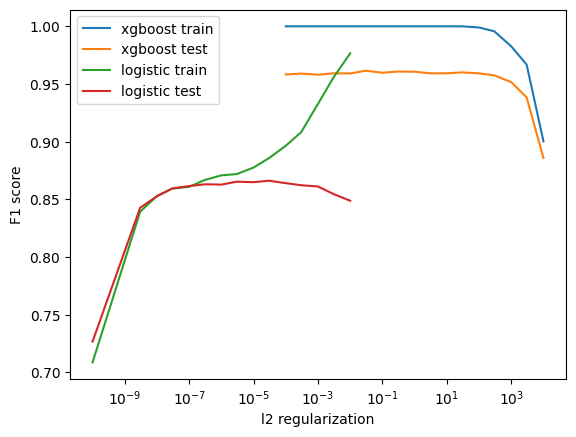

In [16]:
stats_xgb=np.loadtxt("xgb_43sets_gal-type_star_v1.txt")
stats_log=np.loadtxt("log_43sets_gal-type_star_v1.txt")
plt.plot(stats_xgb[0],stats_xgb[1],label='xgboost train')
plt.plot(stats_xgb[0],stats_xgb[2],label='xgboost test')
plt.plot(stats_log[0],stats_log[1],label='logistic train')
plt.plot(stats_log[0],stats_log[2],label='logistic test')
plt.legend(loc="best")
#plt.title('Loss vs Epochs')
plt.xlabel('l2 regularization')
plt.ylabel('F1 score')
plt.xscale("log")

As before the maximum is not clear for xgboost test. For logistic it is clear even wothoit running all regularizations. Xgboost is cleary better than logistic. 

Then I look on log loss. 


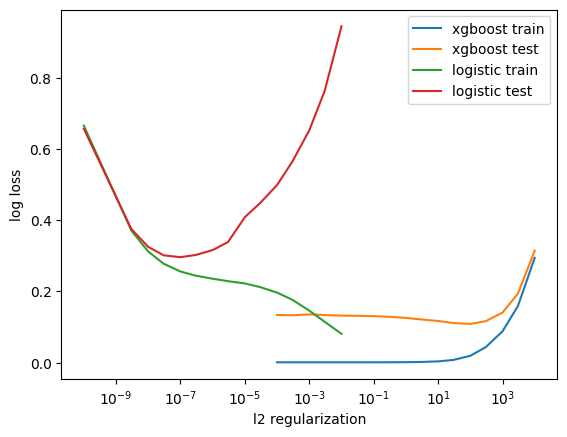

In [17]:
plt.plot(stats_xgb[0],stats_xgb[3],label='xgboost train')
plt.plot(stats_xgb[0],stats_xgb[4],label='xgboost test')
plt.plot(stats_log[0],stats_log[3],label='logistic train')
plt.plot(stats_log[0],stats_log[4],label='logistic test')
plt.legend(loc="best")
#plt.title('Loss vs Epochs')
plt.xlabel('l2 regularization')
plt.ylabel('log loss')
#plt.ylim(0,0.7)
plt.xscale("log")

As usual the minimum is clearer hear and it is at a larger value (logistic l2 value is inverse defined from xgboost). 